# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

2021-08-27 12:32:37.315430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-27 12:32:37.315458: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Dataset

In [3]:
dataset = pd.read_csv('../data/processed_data/active_users_df_10PlusRatings_partial.csv')

In [4]:
anime_df = pd.read_csv('../data/raw_data/anime.csv')

In [5]:
dataset

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,21,10
4,0,24,9
...,...,...,...
822413,4998,6758,7
822414,4998,2001,8
822415,4998,5005,8
822416,4998,12431,7


In [6]:
dataset.shape

(822418, 3)

In [7]:
num_users = len(dataset.user_id.unique())
num_animes = len(dataset.anime_id.unique())
print('Number of animes', num_animes)
print('Number of users', num_users)

Number of animes 12106
Number of users 4035


In [8]:
train, test = train_test_split(dataset, test_size=0.2)

In [9]:
train.head()

,user_id,anime_id,rating
134502,792,36038,6
516365,3081,37086,9
807992,4916,11285,9
286287,1626,36474,8
220195,1264,31758,9


In [10]:
test.head()

,user_id,anime_id,rating
396801,2317,37806,6
679394,4096,3102,7
122614,745,10711,7
757214,4618,32998,8
622814,3715,34618,8


In [11]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (657934, 3)
test shape:  (164484, 3)


# GMF


## Matrix factorisation

In [12]:
import pydot
import graphviz
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
%matplotlib inline

In [13]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, concatenate
from tensorflow.keras.utils import model_to_dot
#from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

In [40]:
# Let's use a higher latent dimension.
latent_dim = 10

anime_input = Input(shape=[1],name='anime-input')
anime_embedding = Embedding(num_animes + 1, latent_dim, name='anime-embedding')(anime_input)
anime_vec = Flatten(name='anime-flatten')(anime_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = concatenate([anime_vec, user_vec],name='dot-product')

model = Model([user_input, anime_input], prod)
model.compile('adam', 'mean_squared_error')

In [41]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anime-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime-embedding (Embedding)     (None, 1, 10)        121070      anime-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        40360       user-input[0][0]                 
____________________________________________________________________________________________

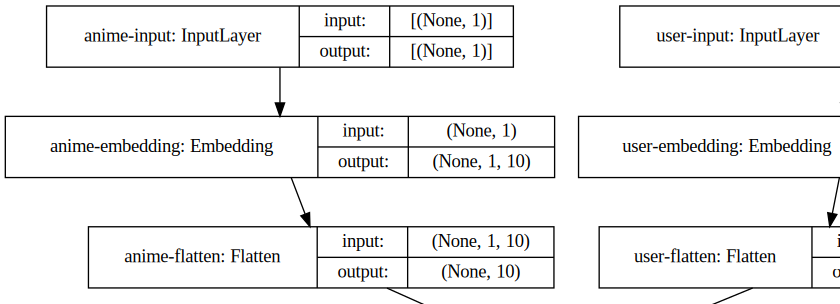

In [16]:
# display
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model.fit([train.user_id, train.anime_id], train.rating, epochs=10)

Epoch 1/10


InvalidArgumentError:  indices[0,0] = 4900 is not in [0, 4036)
	 [[node model_5/user-embedding/embedding_lookup (defined at tmp/ipykernel_21211/3928611106.py:4) ]] [Op:__inference_train_function_4147]

Errors may have originated from an input operation.
Input Source operations connected to node model_5/user-embedding/embedding_lookup:
 model_5/user-embedding/embedding_lookup/3915 (defined at usr/lib/python3.9/contextlib.py:117)

Function call stack:
train_function


In [ ]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)